# I-94 Interstate higway: what causes heavy traffic?

In this project we'll analyze a dataset compiled by John Hogue and available here. This dataset contains information related to the I94 Highway as: weather, temperature, traffic volume, etc.

Our goal is to determine some indicators that correlate to heavy traffic.

In [1]:
import pandas as pd

# Importing the data and examining its columns and column types
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'])

print(traffic.head())
traffic.info()

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description           date_time  traffic_volume  
0    scattered clouds 2012-10-02 09:00:00            5545  
1       broken clouds 2012-10-02 10:00:00            4516  
2     overcast clouds 2012-10-02 11:00:00            4767  
3     overcast clouds 2012-10-02 12:00:00            5026  
4       broken clouds 2012-10-02 13:00:00            4918  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 n

Everything seems good, and there is no null values. We'll proceed to plot the data distribution for the `traffic_volume` column and some statistical indicators.

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64


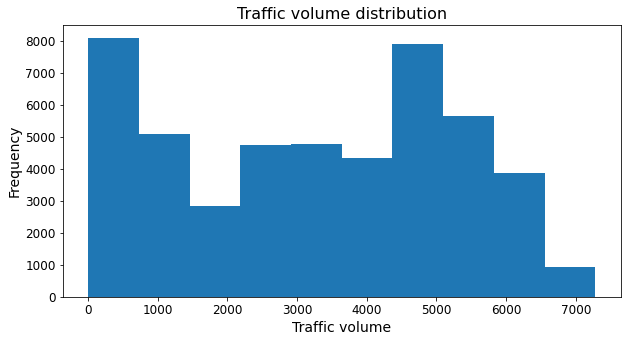

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

print(traffic['traffic_volume'].describe())
plt.figure(figsize=(10,5))
plt.hist(traffic['traffic_volume'])
plt.title('Traffic volume distribution', size=16)
plt.xlabel('Traffic volume', size=14)
plt.ylabel('Frequency', size=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12);

First off we'll have to define what is heavy traffic, the graph above shows that the frequency of two intervals is higher than the rest. So, we'll define the first interval (0-728) as light traffic and beyond the first value of the second interval (around 5000) we'll consider as heavy traffic.

Traffic mean at 3259 located lower than half of the total values distribution (0-7280), this tells us that light traffic is more common than heavy heavy traffic on this segment of the I94. This is supported by the quartiles displayed above, that show that the distribution is minimally accumulated towards lower values.

The histogram shows us that most values are accumulated on the 0 to 728 bin and in the 4,368 to 5,096 bin. This makes us believes that the I94 heavy traffic is related to a bi-periodical variable such as daylight, which can have to values: night or day.

## Hour of the day as a traffic indicator

In [3]:
#Separating day and night data by hour
day_traffic = traffic[(traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19)].copy()
night_traffic = traffic[(traffic['date_time'].dt.hour >= 19) | (traffic['date_time'].dt.hour < 7)].copy()

With the data separated we can proceed to plot the distribution of the `traffic_volume` column in each data subset.

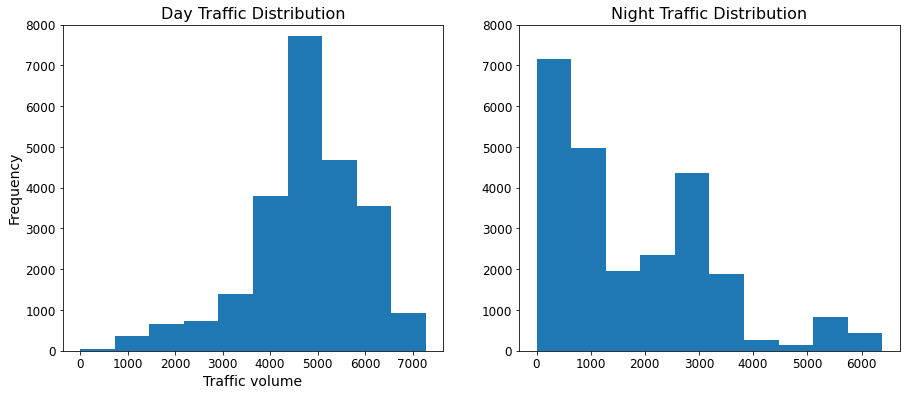

In [4]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.hist(day_traffic['traffic_volume'])
plt.title('Day Traffic Distribution', size=16)
plt.ylabel('Frequency', size=14)
plt.xlabel('Traffic volume', size=14)
plt.ylim([0,8000])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.subplot(1,2,2)
plt.hist(night_traffic['traffic_volume'])
plt.title('Night Traffic Distribution', size=16)
plt.ylim([0,8000])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

Day traffic histogram accumulates values towards the right of the graph, indicating that at day there's generally high traffic. On the contrary, the night traffic histogram accumulates values towards the left of the graph, indicating that at night there's usually no heavy traffic.

This data indicates that we should focus solely on the hours that heavy traffic occurs i.e. day time.

Now that we have identified our hour window to look for heavy traffic indicators, we'll evaluate if there's also a relationship between the month and day of the week with heavy traffic.

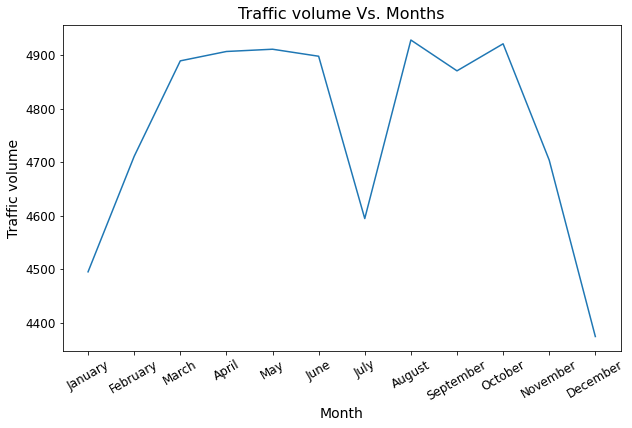

In [5]:
#Creating a column to form groups and separate the data
day_traffic['month'] = day_traffic['date_time'].dt.month

#Grouping the data by the created column
by_month = day_traffic.groupby('month').mean()

plt.figure(figsize=(10,6))
plt.plot(by_month['traffic_volume'])
plt.title('Traffic volume Vs. Months', size=16)
plt.xlabel('Month', size=14)
plt.ylabel('Traffic volume', size=14)
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
           labels=['January', 'February', 'March', 'April', 'May', 'June', 'July',
                   'August', 'September', 'October', 'November', 'December'], rotation=30,
           fontsize=12)
plt.yticks(fontsize=12);

The graph shows us that traffic volume increases from January to March, then it stays stable at around 4,900 until a dramatic descent in traffic in July, from which it increases again and stays stable until November and December, where it exhibits the lowest traffic annualy at around 4,400.

There are low traffic months on: January, July, and December. 

High traffic months on: March, April, May, August, September, and October.

Now we'll proceed to plot the traffic data by day of the week.

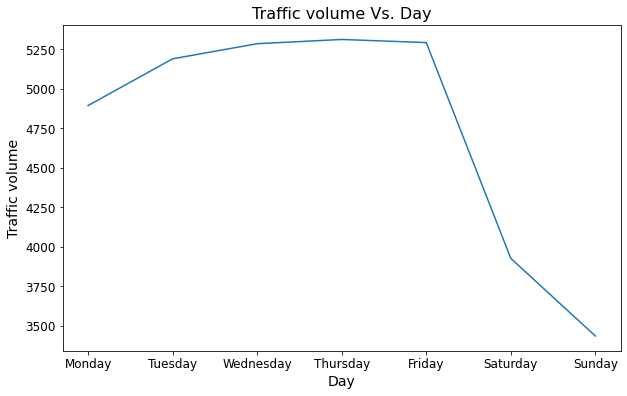

In [6]:
#Creating a column to form groups and separate the data
day_traffic.loc[:, 'dayofweek'] = day_traffic.loc[:, 'date_time'].dt.dayofweek

#Grouping the data by the created column
by_dayofweek = day_traffic.groupby('dayofweek').mean()

#Plotting the data
plt.figure(figsize=(10,6))
plt.plot(by_dayofweek['traffic_volume'])
plt.title('Traffic volume Vs. Day', size=16)
plt.xlabel('Day', size=14)
plt.ylabel('Traffic volume', size=14)
plt.xticks(ticks=[0,1,2,3,4,5,6], 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12);

As expected, all days of the week exhibit high traffic except on weekends, where the traffic volume is fairly low. This pattern fits with the usual commute of most people.

In the next section we'll breakdown the traffic volume into hours and separate working days from weekends.

In [7]:
#Create a column to group data in the next step
day_traffic.loc[:, 'hour'] = day_traffic['date_time'].dt.hour

#Separate data into working days and weekends
bussiness_days = day_traffic.copy()[day_traffic['dayofweek'] <= 4]
weekend = day_traffic.copy()[day_traffic['dayofweek'] >= 5]

#Grouping the previous separated data by hour
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

After succesfully groupinh the data we'll proceed to plot it.

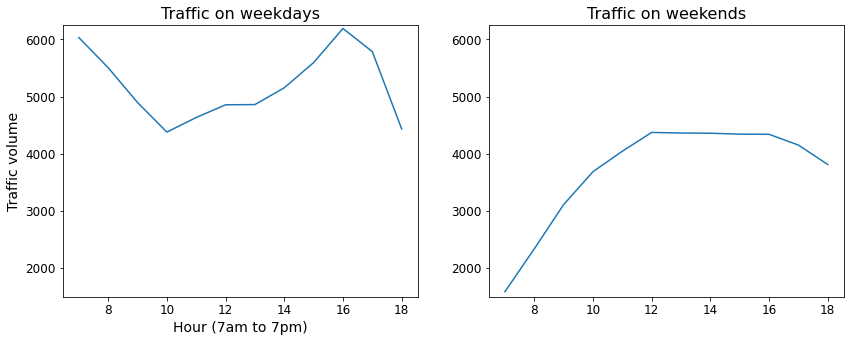

In [8]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(by_hour_business['traffic_volume'])
plt.ylim([1500, 6250])
plt.xlabel('Hour (7am to 7pm)', size=14)
plt.ylabel('Traffic volume',size=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Traffic on weekdays', size=16)

plt.subplot(1,2,2)
plt.plot(by_hour_weekend['traffic_volume'])
plt.ylim([1500, 6250])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Traffic on weekends', size=16)

plt.show()

This graphs give us more detail on the traffic volume during the weekdays and weekends. During business days traffic volume maintains fairly high, with peaks at 7 am and 4 pm. Traffic volume reaches its minimums at 10 am, from where it rises continually until the second rush hour (4 pm).

Weekends on the other hand, exhibits low traffic volume in comparison with the business days. Traffic volume reaches its peak at around 12 pm, but never exceeds our high traffic volume threshold of 5000, it then decreases after 4 pm.

After examining time variables as heavy traffic indicators, now we can proceed to analyse the weather as another possible indicator.

## Weather as a traffic indicator

In [9]:
#printing correlation values between numerical variables an traffic_volume

print(traffic.corr()['traffic_volume'])

temp              0.130299
rain_1h           0.004714
snow_1h           0.000733
clouds_all        0.067054
traffic_volume    1.000000
Name: traffic_volume, dtype: float64


The previous correlation matrix doesn't show any indicative that any of the numeric weather linked variables correlate to the traffic volume. `temp` has the relative highest correlation value, so we'll plot it next.

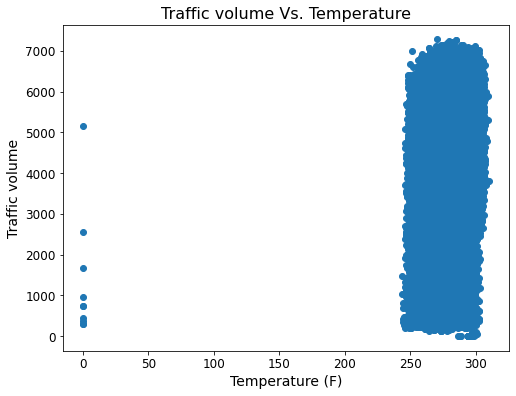

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(traffic['temp'], traffic['traffic_volume'])
plt.xlabel('Temperature (F)', size=14)
plt.ylabel('Traffic volume', size=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Traffic volume Vs. Temperature', size=16);

As we see in our previous analysis, there is no correlation between the temperature variable and the traffic volume.

Next, we'll focus weather categories as possible indicators of heavy traffic. We'll use the columns `weather_main` to group by main weather categories and `weather_desciption` to group data.

In [11]:
#Groping data by main weather categories

by_weather_main = day_traffic.groupby('weather_main').mean()

#grouping data by weather subcategories

by_weather_description = day_traffic.groupby('weather_description').mean()

Now that the data is grouped in different variables we can proceed with the plots. We'll start by plotting main weather categories against traffic volume.

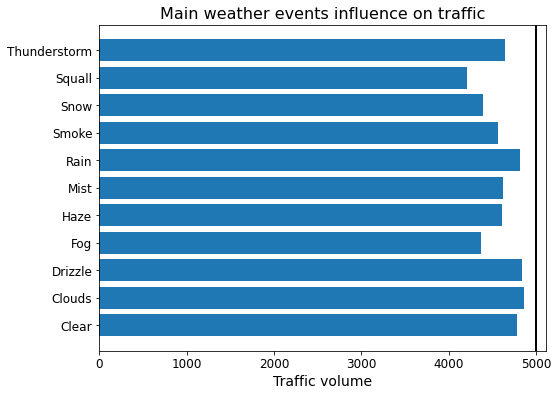

In [12]:
plt.figure(figsize=(8,6))
plt.barh(by_weather_main.index, by_weather_main['traffic_volume'])
plt.axvline(x=5000, color='black', linewidth=2)
plt.xlabel('Traffic volume', size=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Main weather events influence on traffic', size=16);

None of the weather categories above crossed our threshold for heavy traffic, meaning that in average none of them indicate heavy traffic. But, main weather categories subdivide into more descriptive subcategories that we'll plot next.

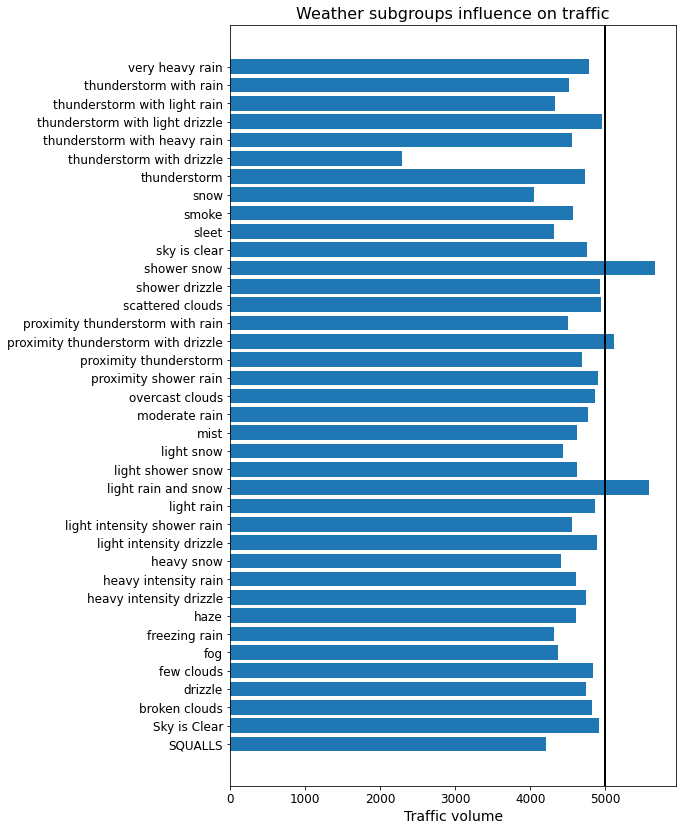

In [13]:
plt.figure(figsize=(8,14))
plt.barh(by_weather_description.index, by_weather_description['traffic_volume'])
plt.axvline(x=5000, color='black', linewidth=2)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Traffic volume', size=14)
plt.title('Weather subgroups influence on traffic', size=16);

This analysis shows that three weather events might be responsible for heavy traffic, these are a shower snow, a light shower snow and a proximity thunderstorm with drizzle.

## Conclusions

From our analysis we can extract several heavy traffic indicators and classified them as time based, and weather based.

#### Time based indicators: 
- March, April, May, August, September, and October.
- Weekdays
- Rush hours at 7 am and 4 pm

#### Weather based indicators:
- You can expect heavy traffic during a shower snow, a light shower snow, or a proximity thunderstorm with drizzle.